In [11]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

True
12.1
NVIDIA GeForce GTX 1650


In [12]:
import os
import time
import torch
from ultralytics import YOLO

In [13]:
class Args:
    # 👇 Change this path to your actual dataset YAML
    data = "Palmistry.v1i.yolov8\data.yaml"
    model = "yolov8n.pt"
    imgsz = 416
    batch = 4
    epochs = 50
    patience = 10
    project = "palmistry_train"
    name = "yolov8n_run"
    device = None   # "cuda", "cpu", or None (auto)

def get_args():
    return Args()


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\SID\AppData\Local\Temp\ipykernel_21328\3073898083.py:3: SyntaxWarning: invalid escape sequence '\d'
  data = "Palmistry.v1i.yolov8\data.yaml"


In [14]:
def auto_adjust_batch(batch):
    # ensure batch at least 1
    return max(1, int(batch))

In [15]:
def try_train(model, data, imgsz, batch, epochs, patience, project, name, device):
    print(f"\nStarting training with model={model}, imgsz={imgsz}, batch={batch}, epochs={epochs}, device={device}\n")
    attempt = 0
    cur_batch = batch
    while True:
        attempt += 1
        try:
            ymodel = YOLO(model)
            ymodel.train(
                data=data,
                epochs=epochs,
                imgsz=imgsz,
                batch=cur_batch,
                device=device,
                project=project,
                name=name,
                patience=patience,
                workers=2,
                save=True
            )
            print("Training finished successfully.")
            return ymodel
        except RuntimeError as e:
            msg = str(e).lower()
            print(f"\nRuntimeError on attempt {attempt}: {e}\n")
            if 'out of memory' in msg or 'cuda' in msg or 'oom' in msg:
                if cur_batch <= 1:
                    print("Batch is already 1 and still OOM. Try reducing imgsz or use more VRAM / Colab GPU.")
                    raise
                old = cur_batch
                cur_batch = max(1, cur_batch // 2)
                print(f"CUDA OOM detected. Reducing batch from {old} -> {cur_batch} and retrying ...\n")
                torch.cuda.empty_cache()
                time.sleep(2)
                continue
            else:
                raise

In [16]:
def main():
    args = get_args()

    # decide device
    if args.device:
        device = args.device
    else:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)

    # adjust batch size
    start_batch = auto_adjust_batch(args.batch)
    if device == "cuda":
        print(f"Initial batch size: {start_batch}. Will auto-reduce on OOM if necessary.")
    else:
        if start_batch > 4:
            print("CPU detected: reducing batch to 4 to avoid memory issues.")
            start_batch = 4

    # train
    trained_model = try_train(
        model=args.model,
        data=args.data,
        imgsz=args.imgsz,
        batch=start_batch,
        epochs=args.epochs,
        patience=args.patience,
        project=args.project,
        name=args.name,
        device=device
    )

    # locate best weights
    run_dir = os.path.join("runs", "detect", args.name)
    best_path = os.path.join(run_dir, "weights", "best.pt")
    if os.path.exists(best_path):
        print(f"\n✅ Best weights saved at: {best_path}")
    else:
        print("\n⚠️ Could not find best.pt at expected location. Check runs/detect for the latest run folder.")
        if os.path.exists("runs/detect"):
            print("Available runs in runs/detect:")
            for r in sorted(os.listdir("runs/detect")):
                print(" ", r)

    return trained_model


In [17]:
trained_model = main()

Using device: cuda
Initial batch size: 4. Will auto-reduce on OOM if necessary.

Starting training with model=yolov8n.pt, imgsz=416, batch=4, epochs=50, device=cuda

Ultralytics 8.3.199  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Palmistry.v1i.yolov8\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937

KeyboardInterrupt: 

### POST PROCESSING

In [1]:
from ultralytics import YOLO

model = YOLO(r"C:\Users\SID\OneDrive\Desktop\AIML Projs\Palmistry CV\palmistry_train\yolov8n_run3\weights\last.pt")

In [31]:
from pathlib import Path

run_name = "palmistry_train/yolov8n_run3"   # change if your run folder name is different
project_runs_dir = "runs/detect"
weights_path = "palmistry_train/yolov8n_run3/weights/best.pt"

# Cell: helper to auto find best.pt for a run name
def auto_find_best_pt(run_name, runs_dir="runs/detect"):
    runs_dir = Path(runs_dir)
    candidate = runs_dir / run_name / "weights" / "best.pt"
    if candidate.exists():
        return str(candidate)
    # fallback: try latest run that matches run_name substring
    if runs_dir.exists():
        matches = [d for d in runs_dir.iterdir() if run_name in d.name]
        matches = sorted(matches, key=lambda p: p.stat().st_mtime, reverse=True)
        for m in matches:
            cand = m / "weights" / "best.pt"
            if cand.exists():
                return str(cand)
    return None

# If user left weights_path None, try to auto-locate
if weights_path is None and run_name:
    candidate = auto_find_best_pt(run_name, project_runs_dir)
    if candidate:
        weights_path = candidate
        print("Auto-found weights:", weights_path)
    else:
        print("No weights found automatically. Set `weights_path` to your best.pt.")


In [32]:
import math
import cv2
import numpy as np
from skimage.util import img_as_bool
from skimage.morphology import skeletonize

In [33]:
# Cell: core helpers (length/contrasts/mask/branch detection)
CONF_THRESH = 0.25   # confidence threshold (adjust between 0.2–0.5 usually)
IOU_THRESH = 0.45    # NMS IoU threshold

CONF_THRESH = CONF_THRESH  # keep local

THICKNESS = 7
GAP_PIXEL_ABS = 18
GAP_MULTIPLIER = 3.0
LENGTH_LONG_RATIO = 0.60
LENGTH_MED_RATIO = 0.35
CONTRAST_CLEAR = 25.0

def length_from_keypoints(keypoints):
    if not keypoints or len(keypoints) < 2:
        return 0.0
    length = 0.0
    for i in range(len(keypoints)-1):
        x1,y1 = keypoints[i]; x2,y2 = keypoints[i+1]
        length += math.hypot(x2-x1, y2-y1)
    return length

def compute_palm_reference(detections, img_shape):
    h,w = img_shape[:2]
    xs, ys = [], []
    for d in detections:
        bb = d.get("bbox")
        if not bb: continue
        x1,y1,x2,y2 = bb
        xs.extend([x1, x2]); ys.extend([y1, y2])
    if xs and ys:
        return max(1.0, max(ys)-min(ys))
    return h * 0.8

def polyline_mask_from_kpts(image_shape, keypoints, thickness=THICKNESS):
    mask = np.zeros((image_shape[0], image_shape[1]), dtype=np.uint8)
    if len(keypoints) >= 2:
        pts = np.array([(int(round(x)), int(round(y))) for (x,y) in keypoints], np.int32)
        cv2.polylines(mask, [pts], isClosed=False, color=255, thickness=thickness)
        mask = cv2.dilate(mask, np.ones((3,3), np.uint8), iterations=1)
    return mask

def compute_contrast(image_gray, mask):
    inside_vals = image_gray[mask>0]
    if inside_vals.size == 0:
        return 0.0, 0.0, 0.0
    inside_mean = float(np.mean(inside_vals))
    dil = cv2.dilate(mask, np.ones((15,15), np.uint8), iterations=1)
    outside_ring = (dil>0) & (mask==0)
    outside_vals = image_gray[outside_ring]
    outside_mean = float(np.mean(outside_vals)) if outside_vals.size else float(np.mean(image_gray))
    contrast = outside_mean - inside_mean
    return contrast, inside_mean, outside_mean

def detect_breaks_from_keypoints(image_gray, keypoints, gap_pixel_abs=GAP_PIXEL_ABS, gap_mult=GAP_MULTIPLIER):
    if not keypoints or len(keypoints) < 2:
        return 0
    dists = []
    midpoints = []
    for i in range(len(keypoints)-1):
        x1,y1 = keypoints[i]; x2,y2 = keypoints[i+1]
        d = math.hypot(x2-x1, y2-y1)
        dists.append(d)
        midpoints.append(((x1+x2)/2.0, (y1+y2)/2.0))
    med = np.median(dists) if dists else 0.0
    breaks = 0
    for i,d in enumerate(dists):
        if d > gap_pixel_abs or (med>0 and d > med*gap_mult):
            mx,my = int(round(midpoints[i][0])), int(round(midpoints[i][1]))
            h,w = image_gray.shape
            x0 = max(0, mx-2); x1 = min(w, mx+3)
            y0 = max(0, my-2); y1 = min(h, my+3)
            patch = image_gray[y0:y1, x0:x1]
            if patch.size == 0 or float(np.mean(patch)) > 180:
                breaks += 1
    return int(breaks)

def detect_branches_from_mask(mask):
    if mask is None or mask.sum() == 0:
        return 0
    bool_mask = img_as_bool(mask)
    skel = skeletonize(bool_mask).astype(np.uint8)
    kernel = np.ones((3,3), dtype=np.uint8)
    neighbor_count = cv2.filter2D(skel, -1, kernel)
    neighbors = neighbor_count - skel
    junctions = np.logical_and(skel==1, neighbors >= 3)
    return int(np.sum(junctions))

def map_length_to_category(length_px, palm_ref_px, long_ratio=LENGTH_LONG_RATIO, med_ratio=LENGTH_MED_RATIO):
    if palm_ref_px <= 0:
        return "medium"
    ratio = length_px / palm_ref_px
    if ratio >= long_ratio: return "long"
    if ratio >= med_ratio: return "medium"
    return "short"


In [34]:
# Cell: ultralytics result conversion + bbox-only -> JSON function
def ultralytics_to_detections(results, model):
    dets = []
    for r in results:
        if getattr(r, "boxes", None) is None:
            continue
        boxes = r.boxes
        xyxy = boxes.xyxy.cpu().numpy()
        confs = boxes.conf.cpu().numpy()
        cls_ids = boxes.cls.cpu().numpy().astype(int)
        for (x1,y1,x2,y2), conf, cls in zip(xyxy, confs, cls_ids):
            dets.append({
                "label": model.names[int(cls)],
                "confidence": float(conf),
                "bbox": [float(x1), float(y1), float(x2), float(y2)],
                "keypoints": []
            })
    return dets

def detections_to_json_from_ultralytics(detections, image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Can't read image: " + str(image_path))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    palm_ref = compute_palm_reference(detections, img.shape)

    out = {"lines": {}}
    label_map = {"life":"life_line","head":"head_line","heart":"heart_line","fate":"fate_line"}

    mask = None
    for d in detections:
        lbl = d["label"].lower()
        if lbl not in label_map: continue
        name = label_map[lbl]
        present = (d.get("confidence",1.0) >= CONF_THRESH)
        entry = {"present": present, "clarity":"", "length":"","breaks":0, "branches":0}

        x1,y1,x2,y2 = map(int, d["bbox"])
        pad = 8
        h_img, w_img = gray.shape
        xx0 = max(0, x1-pad); yy0 = max(0, y1-pad)
        xx1 = min(w_img-1, x2+pad); yy1 = min(h_img-1, y2+pad)
        crop = gray[yy0:yy1, xx0:xx1]
        if crop.size == 0:
            out["lines"][name] = entry
            continue

        crop_eq = cv2.equalizeHist(crop)
        blur = cv2.GaussianBlur(crop_eq, (5,5), 0)
        edges = cv2.Canny(blur, 50, 150)
        edges = cv2.dilate(edges, np.ones((3,3), np.uint8), iterations=1)
        sk = skeletonize(img_as_bool(edges)).astype(np.uint8)
        length_px = float(np.sum(sk))

        mask = np.zeros_like(gray)
        mask[yy0:yy1, xx0:xx1] = (sk * 255)
        contrast, inside_mean, outside_mean = compute_contrast(gray, mask)
        branches = detect_branches_from_mask(mask)

        contours, _ = cv2.findContours((sk*255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        breaks = max(0, len(contours)-1)

        length_cat = map_length_to_category(length_px, palm_ref)
        if breaks > 0:
            clarity = "broken"
        else:
            clarity = "clear" if contrast >= CONTRAST_CLEAR else "faint"

        entry["clarity"] = clarity
        entry["length"] = length_cat
        entry["breaks"] = int(breaks)
        entry["branches"] = int(branches)
        out["lines"][name] = entry

    for canonical in ["life_line","head_line","heart_line","fate_line"]:
        if canonical not in out["lines"]:
            out["lines"][canonical] = {"present": False, "clarity": "", "length": "", "breaks": 0, "branches": 0}
    return out, mask, img


In [35]:
import json 

In [36]:
# Cell: save helpers
def save_json_for_image(json_obj, output_dir, image_path):
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    base = Path(image_path).stem
    out_path = Path(output_dir) / f"{base}.json"
    with open(out_path, "w") as f:
        json.dump(json_obj, f, indent=2)
    return str(out_path)

def save_debug_image(img, detections, mask, output_dir, image_path):
    base = Path(image_path).stem
    debug = img.copy()
    # draw bboxes
    for d in detections:
        x1,y1,x2,y2 = map(int, d["bbox"])
        cv2.rectangle(debug, (x1,y1), (x2,y2), (0,255,0), 2)
        label = f"{d['label']} {d['confidence']:.2f}"
        cv2.putText(debug, label, (x1, max(15,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    # overlay mask if provided
    if mask is not None:
        colored_mask = cv2.merge([mask, np.zeros_like(mask), np.zeros_like(mask)])
        overlay = cv2.addWeighted(debug, 0.7, colored_mask, 0.3, 0)
        debug = overlay
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    debug_path = Path(output_dir) / f"{base}_debug.jpg"
    cv2.imwrite(str(debug_path), debug)
    return str(debug_path)


In [37]:
# Cell: main inference functions
def infer_single_image(weights, image_path, out_dir="results", conf_thresh=0.5, debug_save=True, imgsz=None):
    model = YOLO(weights)
    # run inference (pass conf and optionally imgsz)
    kwargs = {}
    if imgsz:
        kwargs["imgsz"] = imgsz
    results = model(image_path, conf=conf_thresh, **kwargs)
    detections = ultralytics_to_detections(results, model)
    detections = [d for d in detections if d.get("confidence",1.0) >= conf_thresh]
    json_obj, mask, orig_img = detections_to_json_from_ultralytics(detections, image_path)
    saved_json = save_json_for_image(json_obj, out_dir, image_path)
    dbg_path = None
    if debug_save:
        dbg_path = save_debug_image(orig_img, detections, mask, out_dir, image_path)
    return {"json": saved_json, "debug": dbg_path, "detections": detections}

def process_folder(weights, input_dir, out_dir="results", conf_thresh=0.5, debug_save=True, imgsz=None, exts=(".jpg",".jpeg",".png")):
    paths = []
    for e in exts:
        paths.extend(sorted(glob.glob(os.path.join(input_dir, f"*{e}"))))
    print(f"Found {len(paths)} images in {input_dir}")
    results = []
    for p in paths:
        print("Processing:", p)
        try:
            r = infer_single_image(weights, p, out_dir, conf_thresh, debug_save, imgsz)
            results.append((p, r))
        except Exception as ex:
            print("  Error processing", p, ex)
    return results
 

In [38]:
# Cell: check weights and run either single image or folder
weights_path = r"C:\Users\SID\OneDrive\Desktop\AIML Projs\Palmistry CV\palmistry_train\yolov8n_run3\weights\last.pt"

print("weights_path:", weights_path)
if weights_path is None:
    raise SystemExit("Set weights_path to your trained best.pt or set run_name and rerun the auto-find cell.")


weights_path: C:\Users\SID\OneDrive\Desktop\AIML Projs\Palmistry CV\palmistry_train\yolov8n_run3\weights\last.pt


In [39]:
import matplotlib.pyplot as plt


image 1/1 C:\Users\SID\OneDrive\Desktop\AIML Projs\Palmistry CV\test_images\palm_images\palm_9.jpg: 640x480 1 head, 1 life, 65.7ms
Speed: 6.4ms preprocess, 65.7ms inference, 9.7ms postprocess per image at shape (1, 3, 640, 480)
Saved JSON: outputs\palm_9.json
Saved debug image: outputs\palm_9_debug.jpg


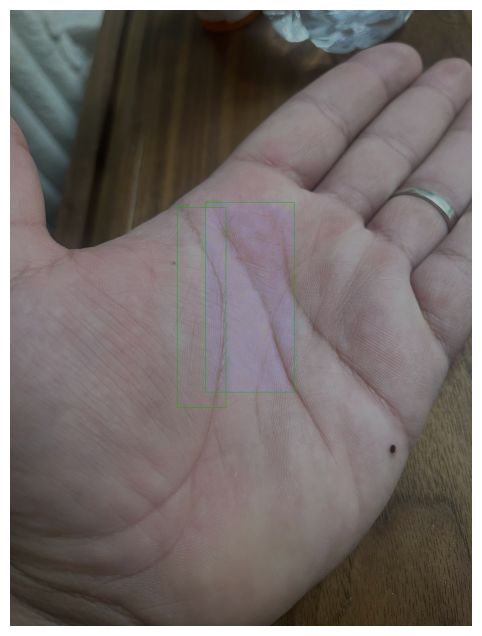

In [41]:
# Cell: run single image inference

# --- Inference config ---
output_dir = "outputs"       # where to save results
DEBUG_SAVE = True            # whether to save debug images
INFER_IMG_SZ = 640           # inference image size (640 is default YOLO size)
CONF_THRESH = 0.25           # confidence threshold (same as during training, usually 0.25)


image_path =  r"C:\Users\SID\OneDrive\Desktop\AIML Projs\Palmistry CV\test_images\palm_images\palm_9.jpg"
out = infer_single_image(weights_path, image_path, out_dir=output_dir, conf_thresh=CONF_THRESH, debug_save=DEBUG_SAVE, imgsz=INFER_IMG_SZ)
print("Saved JSON:", out["json"])
if out["debug"]:
    print("Saved debug image:", out["debug"])
    # show debug image inline
    img = cv2.imread(out["debug"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis("off")
 